## Modeling read depth 

We assume that read depths are Poisson distributed with a mean value that depends on $x$, which could be a feature of the local genomic sequence such as the number of GCs in the interval (as Benjamini and Speed assumed) or an encoding of the raw DNA sequence of the genomic interval under consideration (as we will do). We model the unknown dependence of mean depth on $x$ by a function $H(x)$. 

The goal is to find the function $H(x)$ that maximizes the likelihood that our statistical model would have produced the observed data. 
That likelihood is: 

\begin{equation}
P(N_1=n_1, \ldots, N_m = n_m \, | \,  X_1=x_1,\ldots,X_m=x_m) = \prod_{i=1}^m 
\frac{H(x_i)^{n_i} e^{-H(x_i)}} 
{n_i!},
\end{equation}

where $N_i$ is a random variable representing the read count corresponding to genomic interval $i$ and $n_i$ is the observed read count in that interval.
Maximizing the likelihood is the same as minimizing the negative log-likelihood. Scaling the latter by the number of data points $m$, the task boils down to finding the function $H(x)$ that minimizes the following cost function: 

\begin{equation}
{\cal L} = \frac{1}{m} \sum_{i=1}^m \left[ \, 
H(x_i) - n_i \log H(x_i) + \log \left( n_i! \right)
\, \right] ,
\end{equation}

where $H(x_i)$ is the "predicted" count for interval $i$ and $n_i$ is the "actual"  count. 

In general, there will be many examples (intervals) with the same value of $x$, e.g., there are many 100bp genomic intervals with the same number of GCs. Thus, the summation in the loss function can be rewritten as 

\begin{equation}
\sum_{i=1}^m = \sum_x \sum_{j: x_j = x} .
\end{equation}

For each $x$ in the outer sum,  the value of $H(x)$ that minimizes ${\cal L}$ satisfies:

\begin{equation}
\frac{\partial}{\partial H(x)} \sum_{j: x_j = x} 
\left[ \, 
H(x) - n_j \log H(x) 
\, \right] 
= 0,
\end{equation}

whose solution is: 

\begin{equation}
H(x) = 
\frac
{\sum_{j: x_j = x} n_j}
{\sum_{j: x_j = x}} .
\end{equation}

This is just the average read depth among all intervals with predictor $x$, e.g., the average read depth of intervals with GC content equal to $x$,
which is the model that Benjamini and Speed used. 



## Raw-sequence model

Rather than putting $x$ equal to some aggregated property of a sequence (e.g. GC content), 
we will put $x$ equal to raw DNA sequence, thereby generalizing the Benjamini and Speed model. 
Specifically, we represent $H(x)$ by a neural network, since [neural networks can represent any function](http://neuralnetworksanddeeplearning.com/chap4.html). 
We choose a specific type of neural network---a convolutional neural network---since convolutions enable a neural network to learn features regardless of their position in the 
genomic interval (a property some call "translation invariance"). 


For those sequences $x_i$ that are never repeated in the training set, the 
summation in the maximum 
likelihood estimate of $H(x_i)$ reduces to a single term : 

\begin{equation}
H(x_i) = n_i. 
\end{equation}

In other words, the maximum-likelihood prediction for a sequence $x_i$ is nothing other than the observed read depth associated with that sequence. Substituting $n_i$ for $H(x_i)$ in 
the formula for the cost function leads to the maximum-likelihood cost: 

\begin{equation}
{\cal L}_{ML} = \frac{1}{m} \sum_{i=1}^m \left[ \, 
n_i - n_i \log n_i + \log \left( n_i! \right)
\, \right] .
\end{equation}

The closer ${\cal L}$ is to ${\cal L}_{ML}$, the closer the corresponding predictions are to the observed values. We will use this insight below 
when evaluating the convergence of our learning algorithms.

Note that the function $H(x)$ that maximizes the likelihood is not in general the true function that generated the observed data
since it overfits the training data. Nevertheless, fitting the training data well is 
the first step towards developing a model that generalizes to unseen data, and, as we will see, the better we fit the data, the better we can 
"denoise" it by removing real signal from the observed, noisy signal. 
**The degree to which the cost function  ${\cal L}$ approaches its maximum-likelihood value ${\cal L}_{ML}$
therefore measures the quality of the denoising.**


## Degree of convergence of optimization process

Let's look at the cost associated with predictions that the model made on the training and dev sets:  

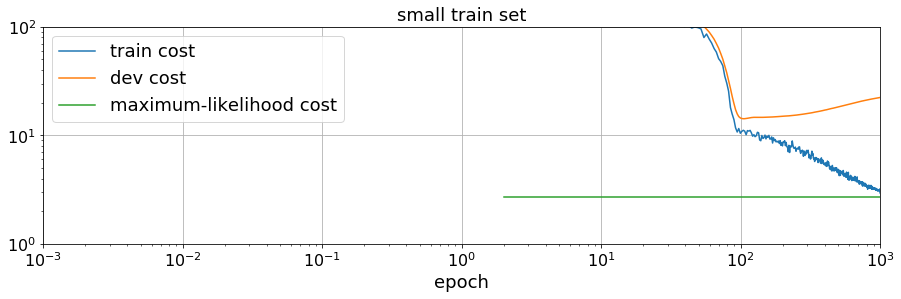

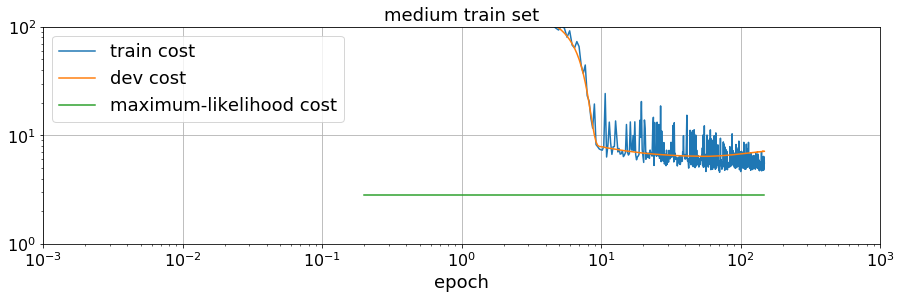

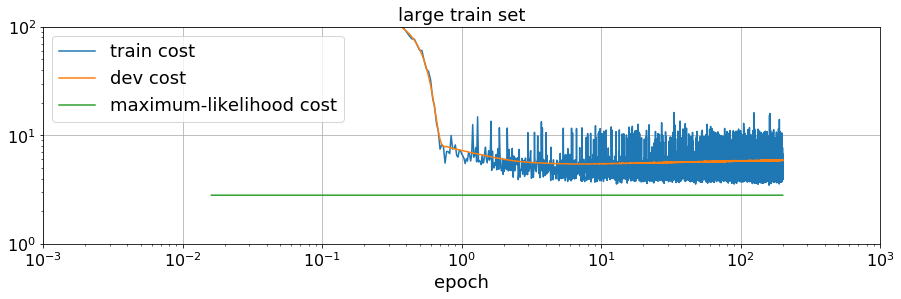

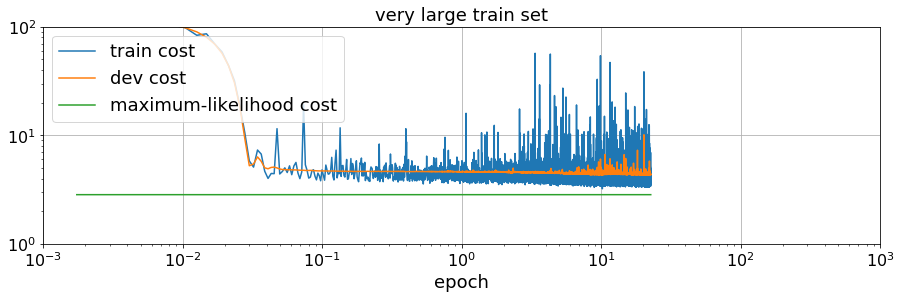

In [7]:
trained_models_averageDepth = [
    {'path': '../data/trained_models/00_new/', 'annotation': 'small train set'},
    {'path': '../data/trained_models/01_new/', 'annotation': 'medium train set'},
    {'path': '../data/trained_models/02_large_learning_rate_longRun/', 'annotation': 'large train set'},
    {'path': '../data/trained_models/03/', 'annotation': 'very large train set'}
]

start_epoch = 0.001
end_epoch = 1000
min_cost = 1
max_cost = 100
loglog = False

%matplotlib inline 
from plot import plot_costs_all
plot_costs_all(trained_models_averageDepth, start_epoch=start_epoch, end_epoch=end_epoch, min_cost=min_cost, max_cost=max_cost, loglog=True)

Judging by the proximity of the value of the converged cost to the maximum-likelihood cost, we would predict that the model denoises small
training data sets but not larger ones...

## Quality of denoising is a reflection of proximity to maximum-likelihood cost value

In the following, "corrected depth" is the observed depth divided by predicted depth whereas "normalized depth" is the observed depth divided by mean depth. 

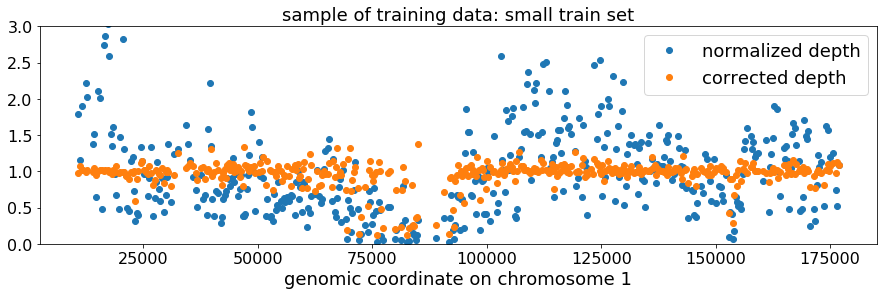

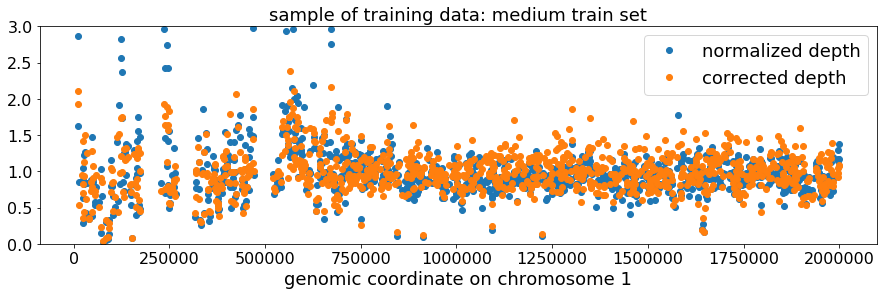

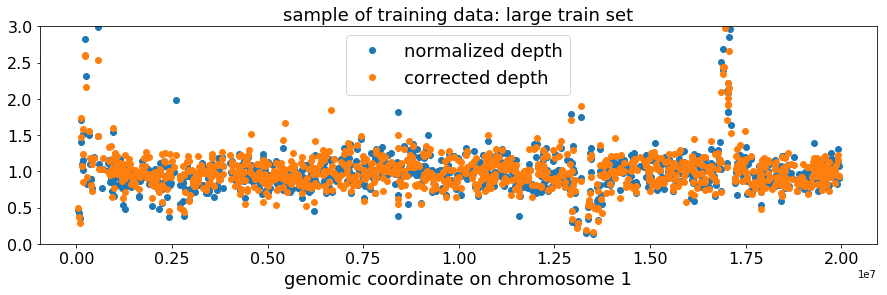

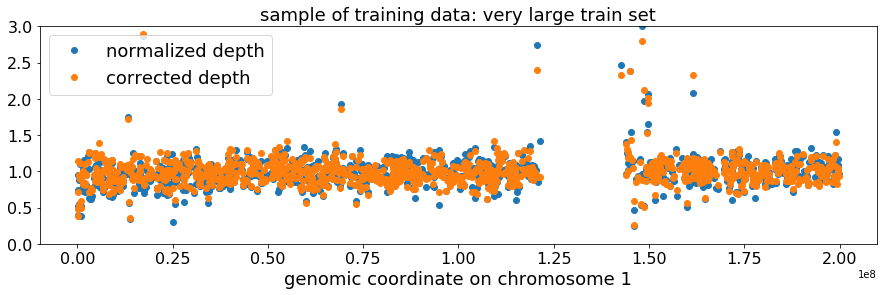

In [2]:
from plot import plot_corrected_depths_train_all
plot_corrected_depths_train_all(trained_models_averageDepth)

As expected, depth profiles are denoised for the small training set, but not for the larger training sets. 

## Labelling genomic intervals with a single depth value instead of an average depth value yields more promising training curves

So far, we have used a training set in which each training example (genomic interval) is labelled with 
the average read-depth value seen throughout the interval. Brent suggested that this may be washing out 
the signal, i.e. smoothing out the true mapping from sequence to depth, making it more challenging to 
learn that mapping. 

To counteract this effect and better preserve the true signal, we relabelled each example with 
the single coverage value corresponding to the central base pair of the interval. 
An additional expected benefit of this approach is that, to the extent that the sequences of different examples overlap, 
the number of examples manifesting a clear signal (e.g. a 7mer that maps to deep coverage) ought to be increased, 
further helping the algorithm to learn. [Think of the result of linear regression on a data set drawn from a step function such that the 
number of examples to the left of the step is 10 and the number to the right is increased from 1 to 10. The regression line would more have a greater slope  when there are an equal number of data points on either side of the step.]

When we retrained our algorithm using the relabelled data set, this is what we see: 

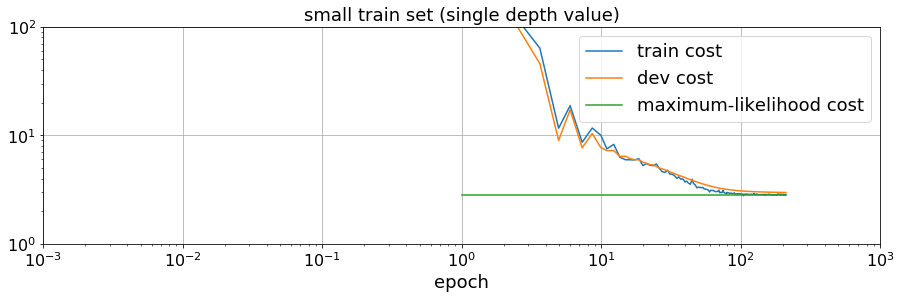

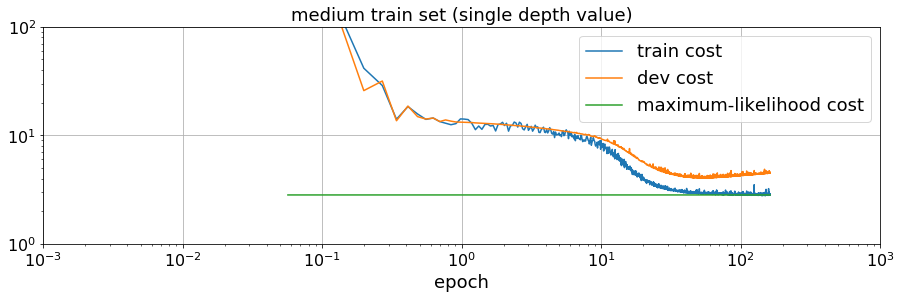

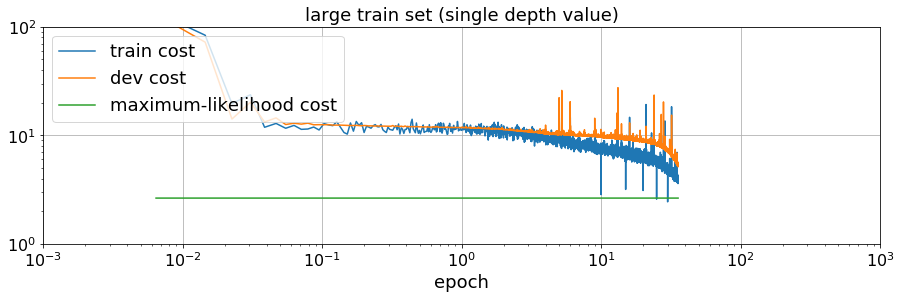

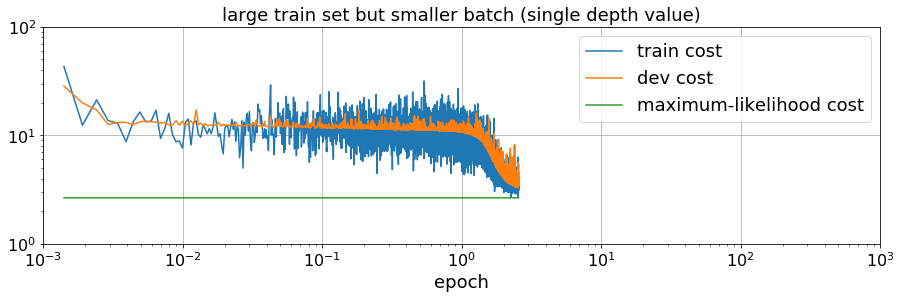

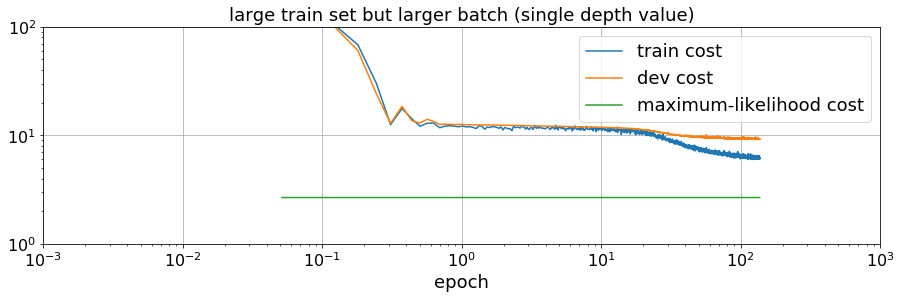

In [8]:
trained_models_exactDepth = [
    {'path': '../data/trained_models/04_smallTrain_exactCoverage/', 'annotation': 'small train set (single depth value)'},
    {'path': '../data/trained_models/05_mediumTrain_exactCoverage/', 'annotation': 'medium train set (single depth value)'},
    {'path': '../data/trained_models/07_largeTrain_exactCoverage_256Batch/', 'annotation': 'large train set (single depth value)'},
    {'path': '../data/trained_models/07_largeTrain_exactCoverage_16Batch/', 'annotation': 'large train set but smaller batch (single depth value)'},
    {'path': '../data/trained_models/07_largeTrain_exactCoverage_2048Batch/', 'annotation': 'large train set but larger batch (single depth value)'},
]

plot_costs_all(trained_models_exactDepth, start_epoch=start_epoch, end_epoch=end_epoch, min_cost=min_cost, max_cost=max_cost, loglog=True)

These training curves show a number of promising features relative to the previous data set:  
* training curves seem to approach maximum-likelihood value more closely  
* training curves are less noisy (at least for reasonably large batch sizes)

In particular, notice that learning on the largest training set has not yet converged, 
in  contrast to the average-depth data set, on which learning had already converged 
by this point. This observation gives us the confidence to continue to train on this data set using the CPU, 
and to generalize the code to run on a GPU, which is expected to acclerate training time ten-fold. 

## The effect of mini-batch size on convergence

The smaller the mini batch, the "sooner" the algorithm can start to descend towards the optimum cost. Decreasing the mini-batch size all the way down to 1 (the mini batch sizes I used on the large training set above are 16, 256, 2048) would in principle aid convergence further but there is a trade-off: the smaller the mini batch size, the less "vectorized" the code is, and the longer it will take to run. This trade-off is visible in the last three training curves: there is a big gain in convergence upon going from 2048 to 256, but there isn't as much to be gained on going from 256 to 16 even though all three experiments were run on the same machine for the same wall-clock duration (about three days). 

## Better denoising on medium and large training sets 

As predicted by the convergence of the training cost on the maximum-likelihood value in the plots above, coverage profiles are better denoised on medium and large training sets for single-depth data sets than for average-depth data sets: 

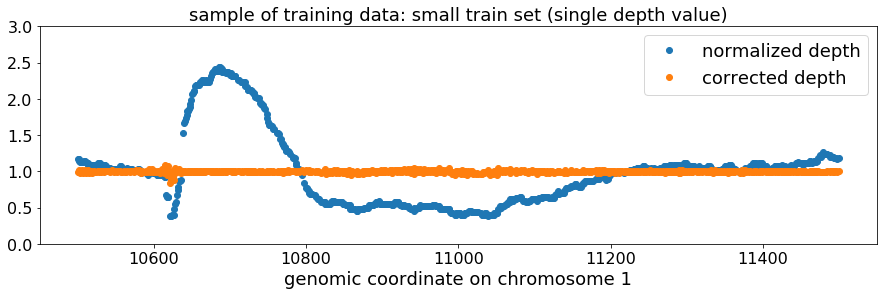

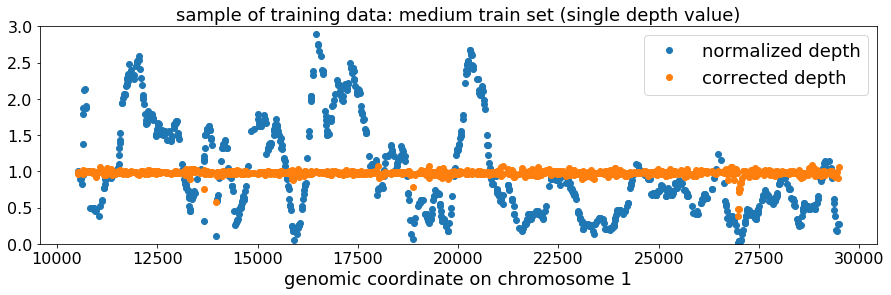

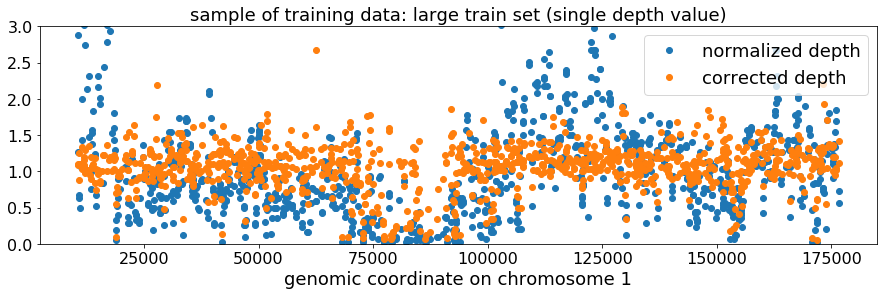

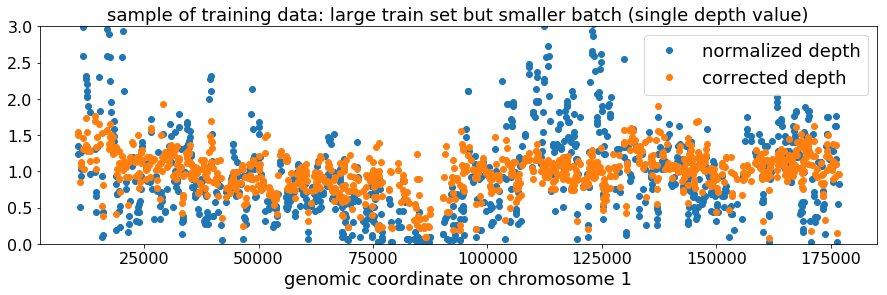

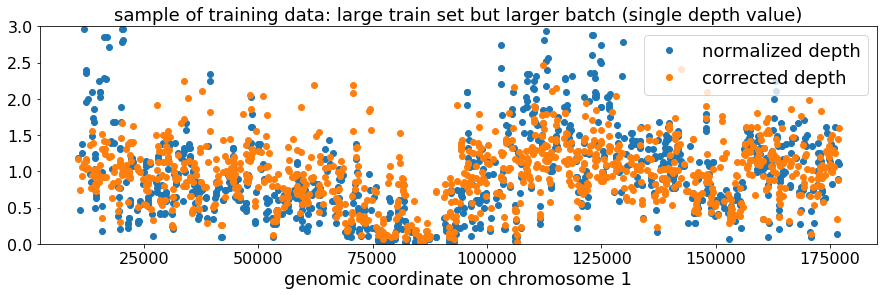

In [4]:
from plot import plot_corrected_depths_train_all
plot_corrected_depths_train_all(trained_models_exactDepth)

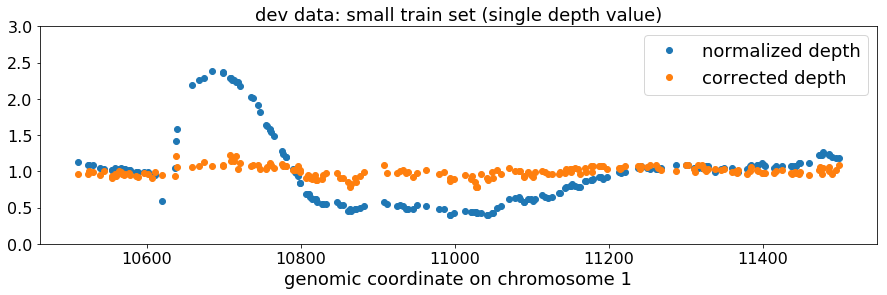

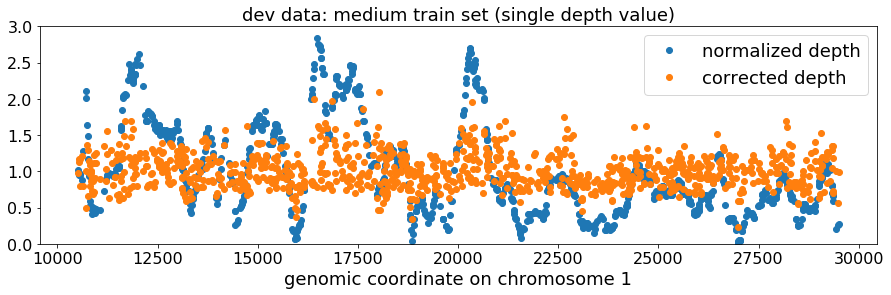

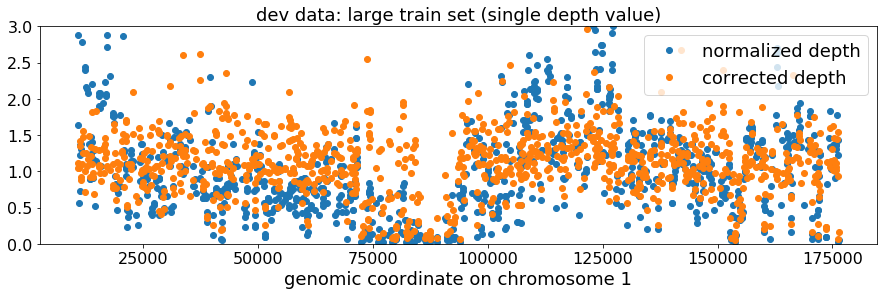

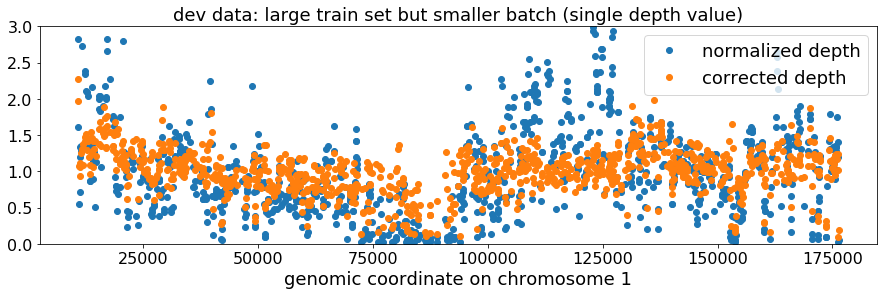

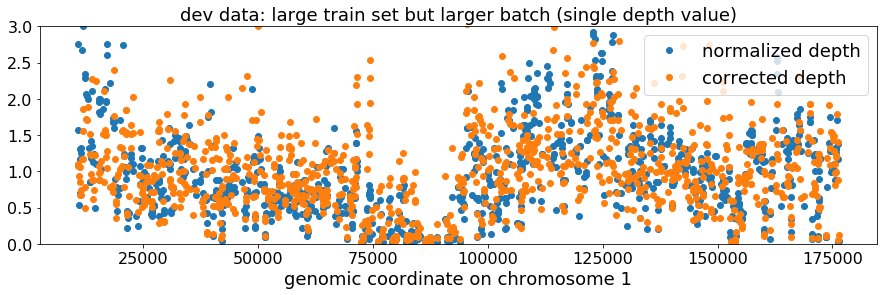

In [5]:
from plot import plot_corrected_depths_dev_all
plot_corrected_depths_dev_all(trained_models_exactDepth)